In [1]:
import os
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord

% matplotlib inline 

In [2]:
DATABASE = "../data/objects.db"
con = sql.connect(DATABASE)

In [3]:
pd.read_sql("""SELECT * FROM observations LIMIT 5""", con)

obsId  designation code    mjd_utc  Delta_au     RA_deg    Dec_deg  \
0      0            1  I11  59580.173  1.902782  57.150799  17.963450   
1      1            1  I11  59580.173  1.902782  57.150799  17.963450   
2      2            1  I11  59581.173  1.911230  57.038472  18.008182   
3      3            1  I11  59582.173  1.919874  56.933118  18.053952   
4      4            1  I11  59583.173  1.928708  56.834805  18.100766   

   dDelta/dt_au_p_day  dRA/dt_deg_p_day  dDec/dt_deg_p_day  ...    \
0            0.008475         -0.115854           0.042977  ...     
1            0.008475         -0.115854           0.042977  ...     
2            0.008676         -0.109128           0.043980  ...     
3            0.008872         -0.102334           0.044991  ...     
4            0.009063         -0.095481           0.046009  ...     

   HEclObj_dX/dt_au_p_day  HEclObj_dY/dt_au_p_day  HEclObj_dZ/dt_au_p_day  \
0               -0.010074                0.002360                0.001932   
1               -0.010074                0.002360                0.001932   
2               -0.010086                0.002322                0.001932   
3               -0.010098                0.002284                0.001933   
4               -0.010109                0.002245                0.001934   

   HEclObsy_X_au  HEclObsy_Y_au  HEclObsy_Z_au     EccAnom    TrueAnom  \
0      -0.177647       0.967200      -0.000080  283.580777  279.328011   
1      -0.177647       0.967200      -0.000080  283.580777  279.328011   
2      -0.194827       0.963877      -0.000079  283.580777  279.328011   
3      -0.211947       0.960252      -0.000078  283.580777  279.328011   
4      -0.229001       0.956326      -0.000077  283.580777  279.328011   

   PosAngle_deg  night  
0    290.352516  59580  
1    290.352516  59580  
2    291.949945  59581  
3    293.732855  59582  
4    295.727612  59583  

[5 rows x 42 columns]

In [4]:
class Config:
    
    objectColumns = ["designation"]
    observationColumns = ["obsId", "mjd_utc", "night"]
    primaryCoordinateSystem = "equatorialAngular"
    additionalCoordinateSystems = ["eclipticAngular", "eclipticCartesian"]
    coordinateColumns = {"equatorialAngular": ["RA_deg",
                                               "Dec_deg",
                                               "Delta_au"],
                         "eclipticAngular": ["HLon_deg",
                                             "HLat_deg",
                                             "r_au"],
                         "eclipticCartesian": ["HEclObsy_X_au",
                                               "HEclObsy_Y_au",
                                               "HEclObsy_Z_au"]}
    velocityColumns = {"equatorialAngular": ["dRA/dt_deg_p_day",
                                             "dDec/dt_deg_p_day",
                                             "dDelta/dt_au_p_day"],
                       "eclipticCartesian": ["HEclObj_dX/dt_au_p_day",
                                             "HEclObj_dY/dt_au_p_day",
                                             "HEclObj_dZ/dt_au_p_day"]}

config = Config()

In [5]:
def findObsInCell(obsIds, coords, coord_center, radius):
    """
    Find the observation IDs in a circular / spherical region 
    about a central point.
    
    Parameters
    ----------
    obsIds : `~np.ndarray` [N, 1]
        Array of observation IDs corresponding to the coords.
    coords : `~np.ndarray` [N, d]
        Array of coordinates of N rows for each observation
        and d dimensions. 
    coord_center : `~np.ndarray` [1, d]
        Array containing coordinates in d dimensions about which
        to search. 
    radius : float
        Search radius.
        
    Returns
    -------
    `~np.ndarray`
        Array of observation IDs that fall within the search radius.
    """
    distances = np.sqrt(np.sum((coords - coord_center)**2, axis=1))
    return obsIds[np.where(distances <= radius)[0]]

def test_findObsInCell_2D():
    # Create a set of points on a grid
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-10, 10, 100)
    xx, yy = np.meshgrid(x, y)
    xx = xx.flatten()
    yy = yy.flatten()
    ids = np.arange(0, len(xx))
    
    # Randomly select some centers and radii
    centers = np.random.choice(len(xx), size=5)
    radii = np.random.rand(5) * 10
    
    for center, radius in zip(centers, radii):
        # Calculate distances and select those that should be inside
        distances = np.sqrt((xx - xx[center])**2 + (yy - yy[center])**2)
        inside = ids[np.where(distances <= radius)[0]]
        np.testing.assert_array_equal(inside,
                                      findObsInCell(ids,
                                                    np.array([xx, yy]).T,
                                                    np.array([xx[center], yy[center]]),
                                                    radius))
test_findObsInCell_2D()

In [16]:
class Cell:
    
    def __init__(self, x, y, radius, night):
        self.center = np.array([x, y])
        self.radius = radius
        self.night = night
        self.children = [self]
        
    def __repr__(self):
        return "x: {}, y: {}, night: {}".format(*self.center, self.night)
        
    def project(self, v, dt, steps):
        for step in range(1, steps):
            child = Cell(*(self.center + v*dt*step), self.radius, self.night+dt*step)
            self.children.append(child)
            print("Child cell created:")
            print(child)

def queryNight(con, night,
               objectColumns=config.objectColumns,
               observationColumns=config.observationColumns,
               primaryCoordinateSystem=config.primaryCoordinateSystem,
               additionalCoordinateSystems=config.additionalCoordinateSystems,
               coordinateColumns=config.coordinateColumns,
               velocityColumns=config.velocityColumns):
    columns = (config.objectColumns
                   + config.observationColumns
                   + config.coordinateColumns[config.primaryCoordinateSystem])

    if config.primaryCoordinateSystem in config.velocityColumns.keys():
        columns + config.velocityColumns[config.primaryCoordinateSystem]

    if config.additionalCoordinateSystems is not None:
        for system in config.additionalCoordinateSystems:
            columns += config.coordinateColumns[system]
            if system in config.velocityColumns.keys():
                columns += config.velocityColumns[system]

    query = ", ".join(columns)
    #night_df = pd.read_sql("""SELECT {} FROM observations
    #                       WHERE night = {}""".format(query, night), con)
    return query

def queryCell(con, cell,
              objectColumns=config.objectColumns,
              observationColumns=config.observationColumns,
              primaryCoordinateSystem=config.primaryCoordinateSystem,
              additionalCoordinateSystems=config.additionalCoordinateSystems,
              coordinateColumns=config.coordinateColumns,
              velocityColumns=config.velocityColumns,
              night=None):
    if night is None:
        night = queryNight(con, cell.night)
    obs_ids = findObsInCell(night["obsId"].values, night[["HLon_deg", "HLat_deg"]].as_matrix(), cell.center, cell.radius)
    obs = night[night["obsId"].isin(obs_ids)]
    return obs


In [17]:
lon = 200
lat = 18
radius = 10
night = 59581
velocity = np.array([1, 0])
cell = Cell(lon, lat, radius, night)
cell.project(velocity, 1, 10)
  

Child cell created:
x: 201, y: 18, night: 59582
Child cell created:
x: 202, y: 18, night: 59583
Child cell created:
x: 203, y: 18, night: 59584
Child cell created:
x: 204, y: 18, night: 59585
Child cell created:
x: 205, y: 18, night: 59586
Child cell created:
x: 206, y: 18, night: 59587
Child cell created:
x: 207, y: 18, night: 59588
Child cell created:
x: 208, y: 18, night: 59589
Child cell created:
x: 209, y: 18, night: 59590


In [120]:
cells

[x: 200, y: 18, night: 59581,
 x: 201, y: 18, night: 59582,
 x: 202, y: 18, night: 59583,
 x: 203, y: 18, night: 59584,
 x: 204, y: 18, night: 59585]

In [121]:
def plotCell(obs, cell, coordinateSystemAngular=config.coordinateSystemAngular, coordinateColumns=config.coordinateColumns):
    
    fig, ax = plt.subplots(1, 1, dpi=200)
    fig.tight_layout()
    ax.set_aspect("equal")
    
    if coordinateSystemAngular == "equatorialAngular":
        ax.scatter(obs[coordinateColumns["equatorialAngular"][0]].values, 
                   obs[coordinateColumns["equatorialAngular"][1]].values,
                   s=0.5)
        ax.set_xlabel(r"$\alpha$ [deg]")
        ax.set_ylabel(r"$\delta$ [deg]")
    elif coordinateSystemAngular == "eclipticAngular":
        ax.scatter(obs[coordinateColumns["eclipticAngular"][0]].values, 
                   obs[coordinateColumns["eclipticAngular"][1]].values,
                   s=0.5)
        ax.set_xlabel(r"$\lambda$ [deg]")
        ax.set_ylabel(r"$\beta$ [deg]")
    else:
        raise NotImplemented("Stupidity is not flattering.")

    cell_p = plt.Circle((cell.center[0], cell.center[1]), cell.radius, color="r", fill=False)
    ax.add_artist(cell_p)
    ax.grid()
    
    
def plotNight(night, cell=None, coordinateSystemAngular=config.coordinateSystemAngular, coordinateColumns=config.coordinateColumns):
    
    if type(night) is int:
        night = pd.read_s
    fig, ax = plt.subplots(1, 1, dpi=200)
    fig.tight_layout()
    ax.set_aspect("equal")

    if coordinateSystemAngular == "equatorialAngular":
        ax.scatter(night[coordinateColumns["equatorialAngular"][0]].values, 
                   night[coordinateColumns["equatorialAngular"][1]].values,
                   s=0.05)
        ax.set_xlabel("RA [deg]")
        ax.set_ylabel("Dec [deg]")
        ax.set_xlim(0, 360)
        ax.set_ylim(-90, 90)
    elif coordinateSystemAngular == "eclipticAngular":
        ax.scatter(night[coordinateColumns["eclipticAngular"][0]].values, 
                   night[coordinateColumns["eclipticAngular"][1]].values,
                   s=0.05)
        ax.set_xlabel(r"$\lambda$ [deg]")
        ax.set_ylabel(r"$\beta$ [deg]")
        ax.set_xlim(0, 360)
        ax.set_ylim(-90, 90)
    else:
        raise NotImplemented("Stupidity is not flattering.")

    if cell is not None:
        cell_p = plt.Circle((cell.center[0], cell.center[1]), cell.radius, color="r", fill=False)
        ax.add_artist(cell_p)

    ax.grid()


AttributeError: 'Config' object has no attribute 'coordinateSystemAngular'

In [122]:
night = queryNight(con, cells[0].night)

In [123]:
night

'designation, obsId, mjd_utc, night, RA_deg, Dec_deg, Delta_au, HLon_deg, HLat_deg, r_au, HEclObsy_X_au, HEclObsy_Y_au, HEclObsy_Z_au, HEclObj_dX/dt_au_p_day, HEclObj_dY/dt_au_p_day, HEclObj_dZ/dt_au_p_day'

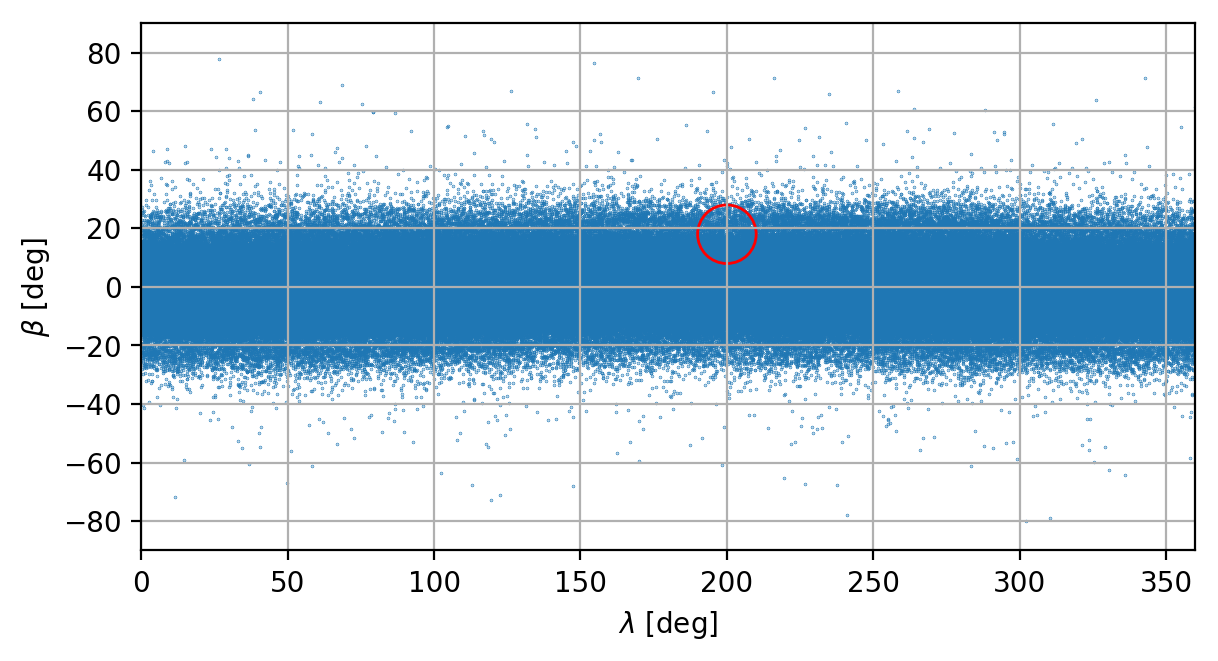

In [47]:
plotNight(night, cells[0])

In [51]:
obs = queryCell(con, cells[0], night=night)

In [6]:
plotCell(obs, cells[4])

NameError: name 'plotCell' is not defined

In [53]:
obss = []
for cell in cells:
    obss.append(queryCell(con, cell))

In [66]:
def phaseFold(obs, cells, velocity):
    folded = []
    for o, c in zip(obs[1:], cells[1:]):
        folded.append(obss[2][["HLon_deg", "HLat_deg"]] - velocity*(c.night - cells[0].night))
        
    return folded

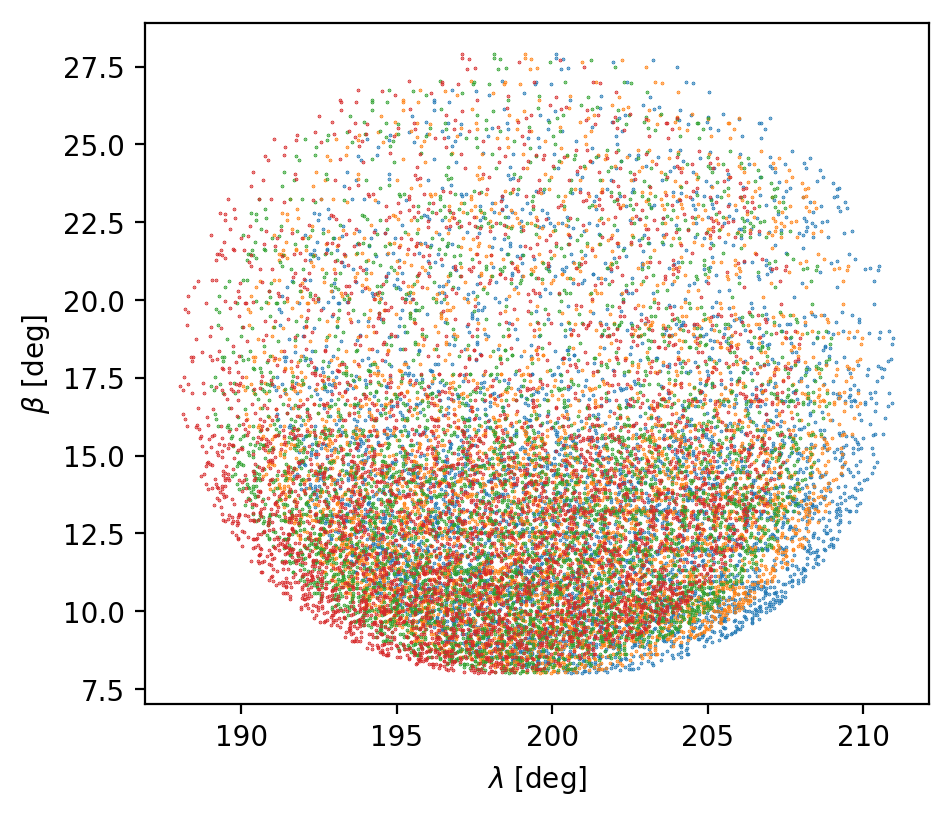

In [94]:
folded = phaseFold(obss, cells, velocity)

fig, ax = plt.subplots(1, 1, dpi=200)
fig.tight_layout()
ax.set_aspect("equal")

for fold in folded:
    ax.scatter(*fold.as_matrix().T, s=0.1)

ax.set_xlabel(r"$\lambda$ [deg]");
ax.set_ylabel(r"$\beta$ [deg]");


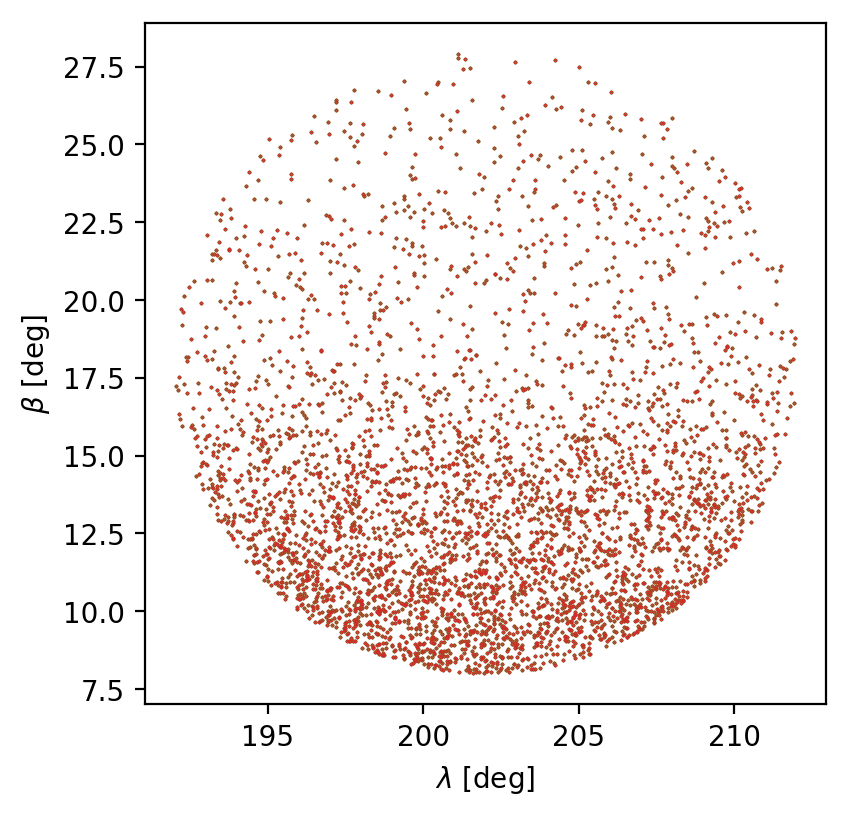

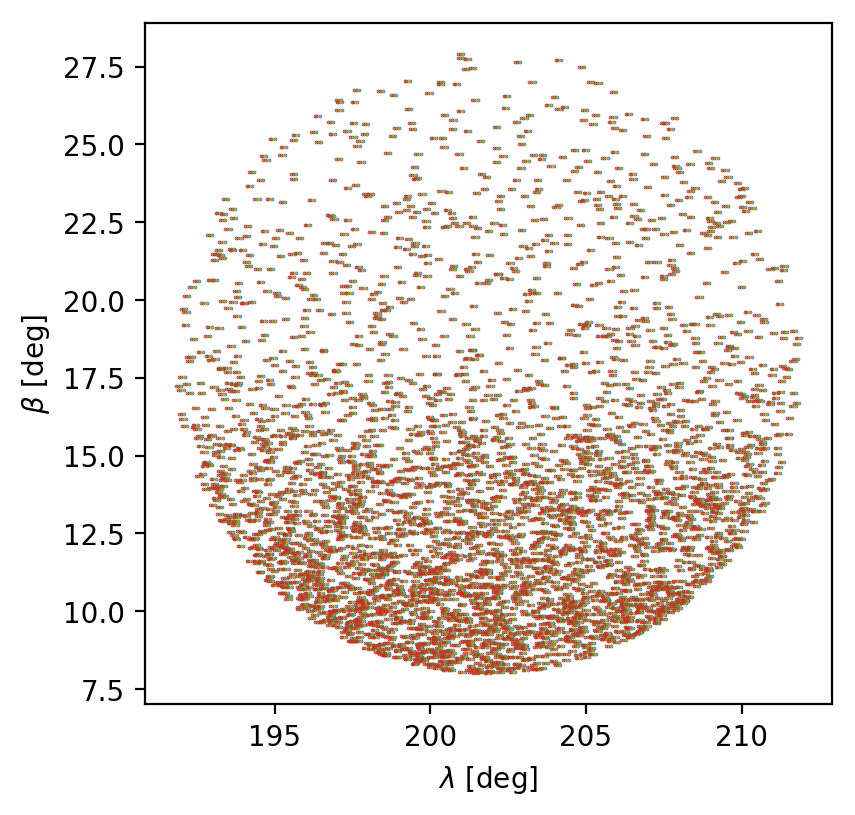

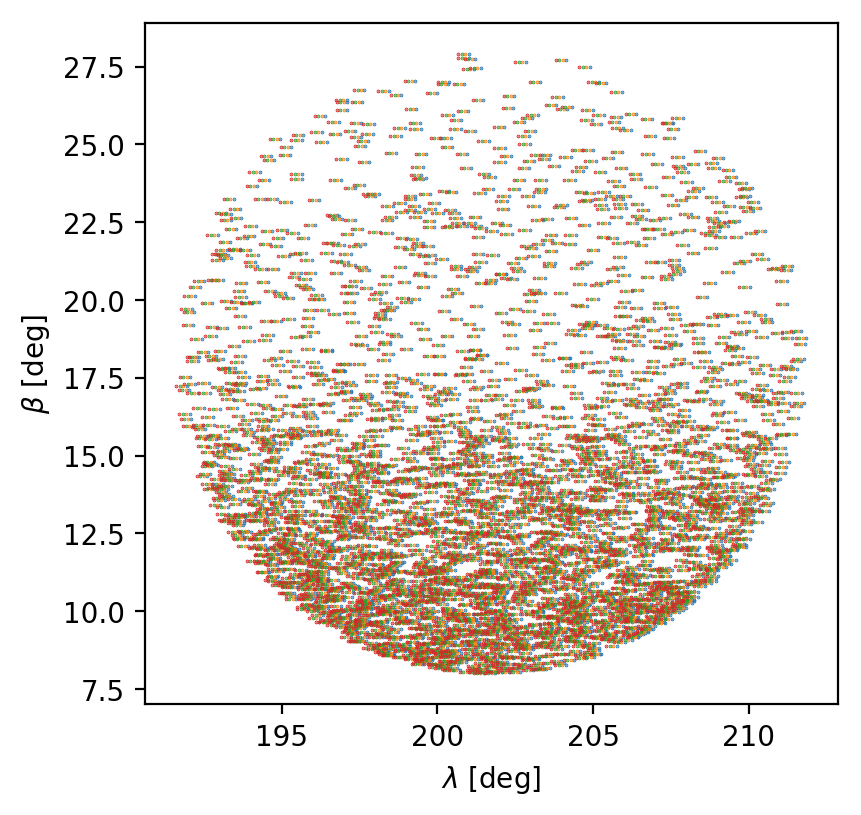

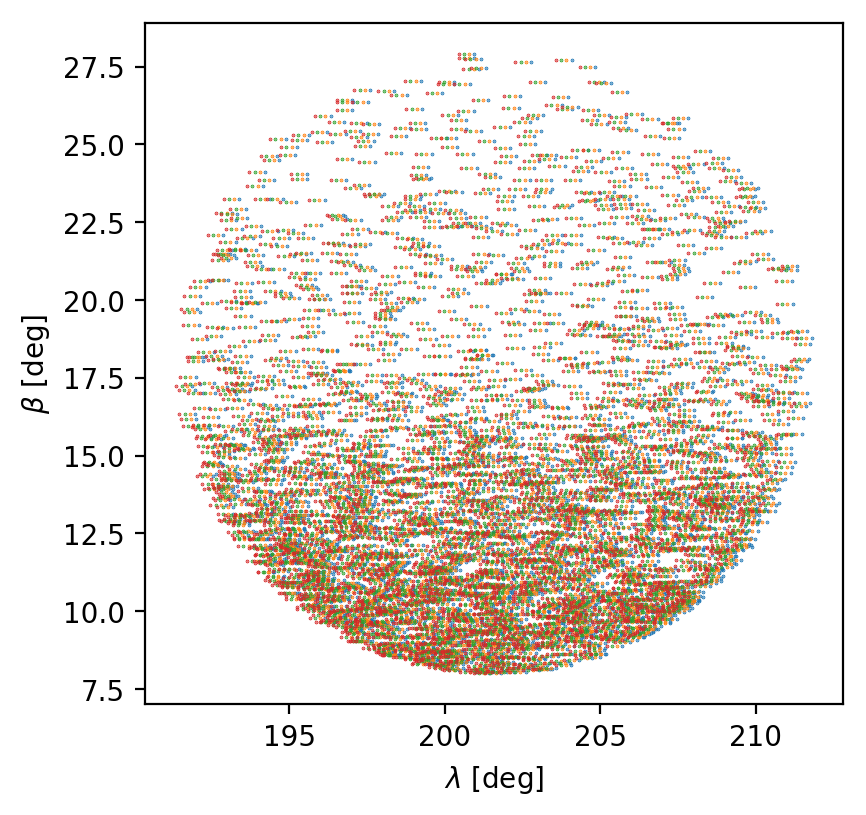

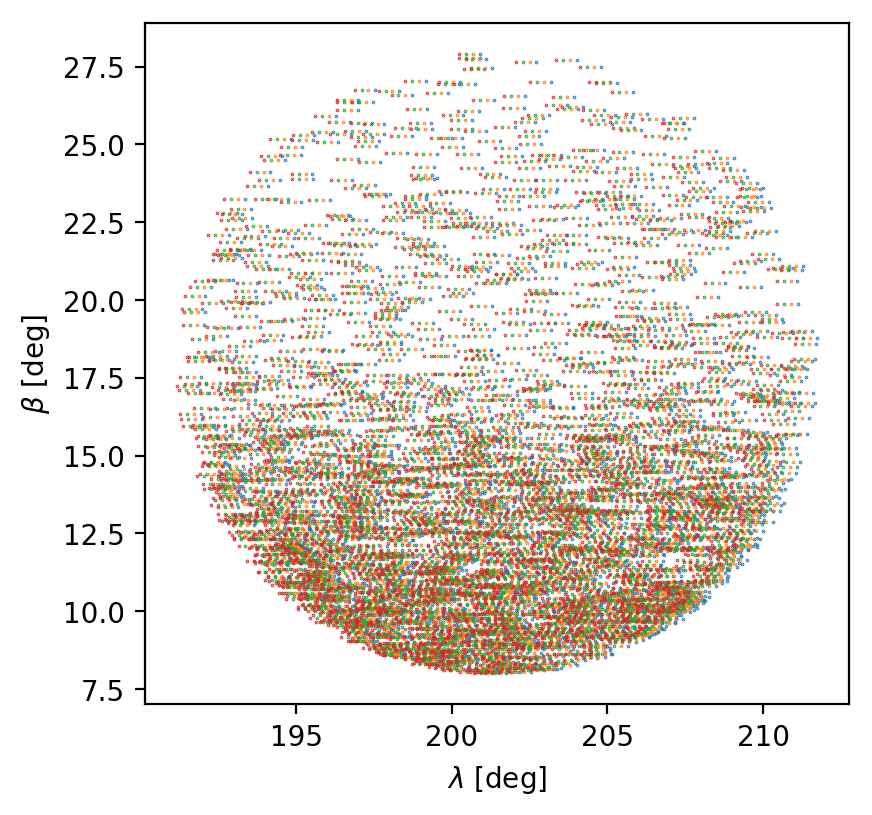

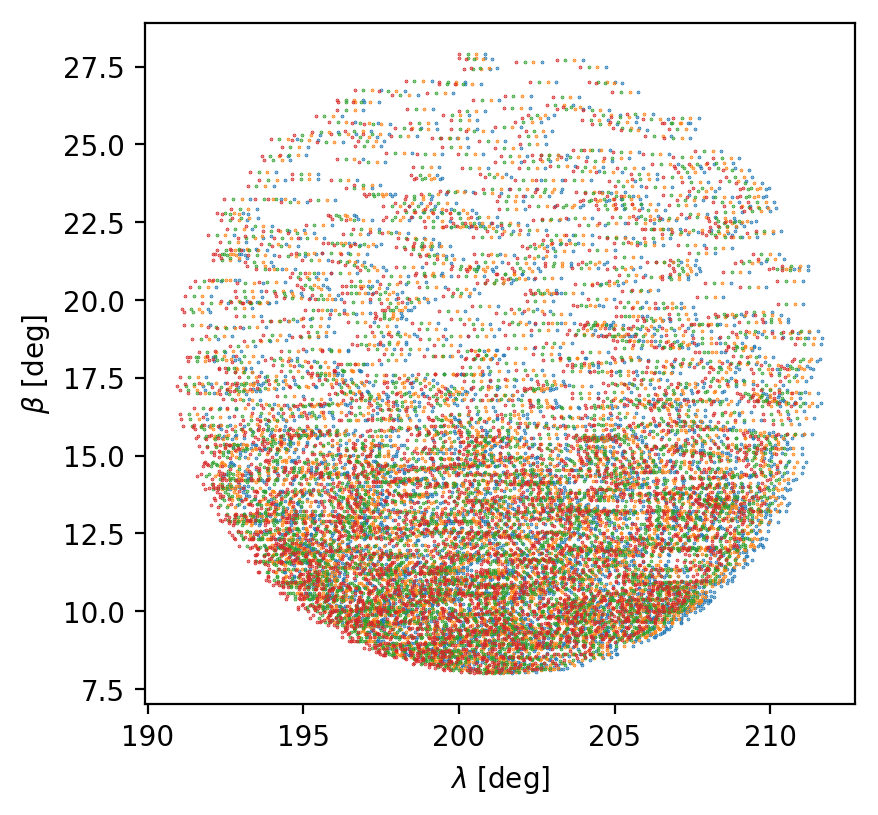

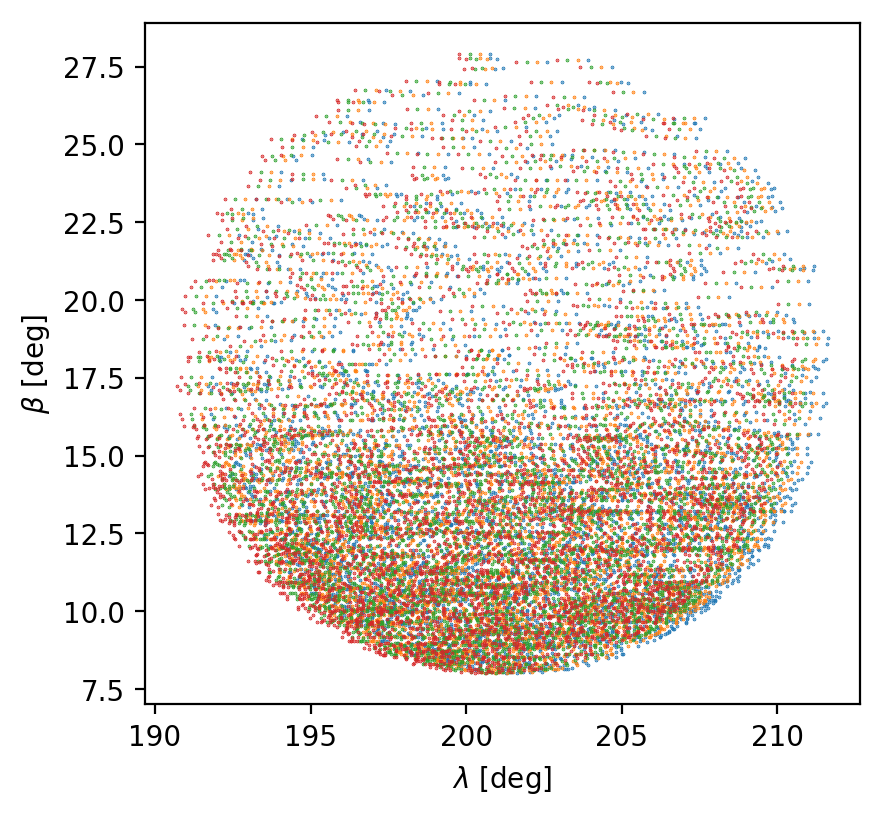

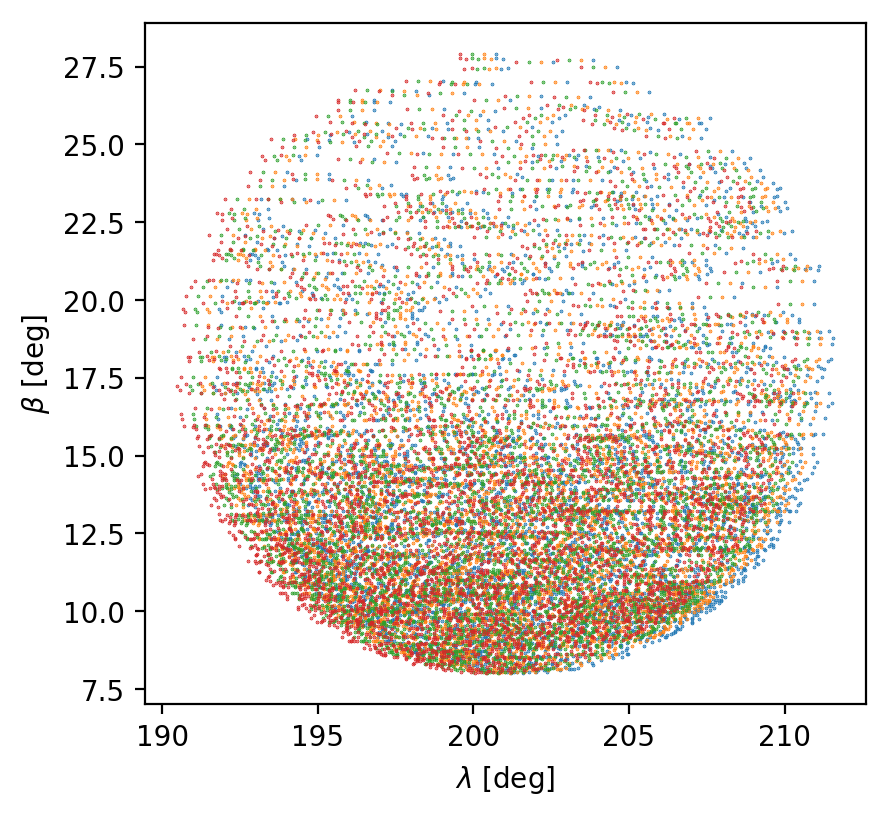

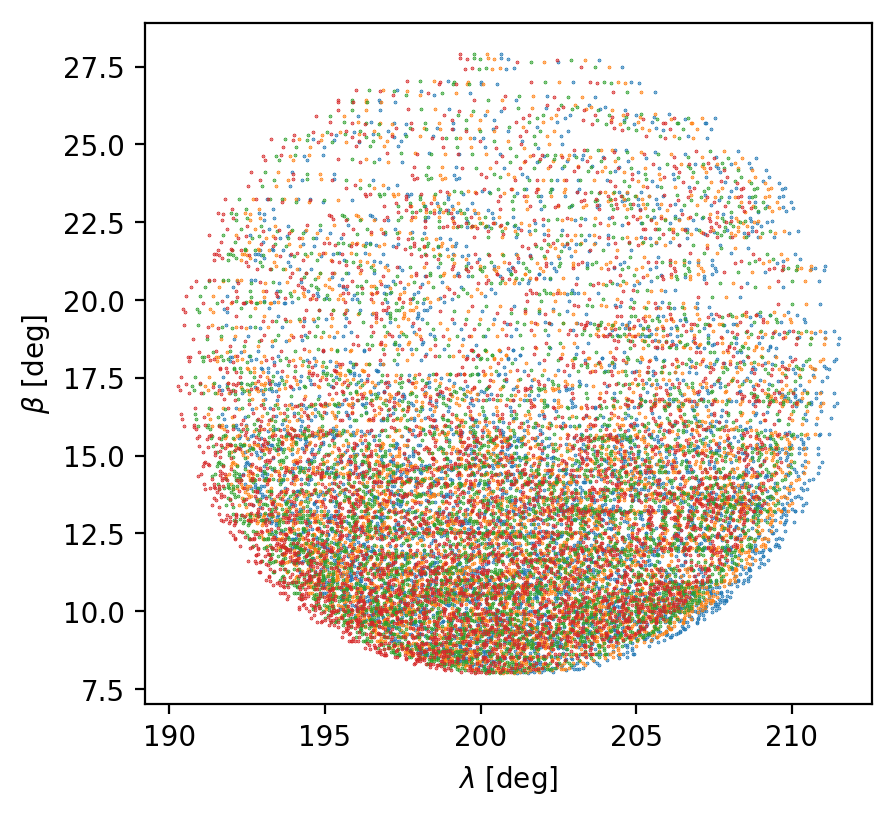

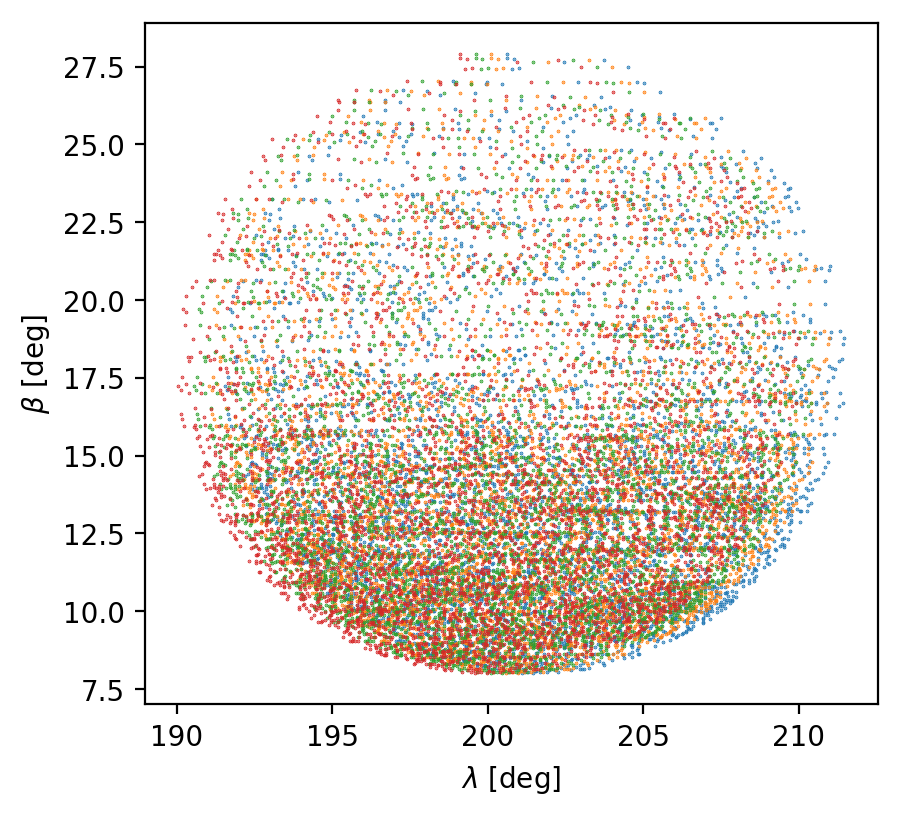

In [92]:
for i, v in enumerate(np.linspace(0, 0.5, 10)):
    folded = phaseFold(obss, cells, np.array([v,0]))

    fig, ax = plt.subplots(1, 1, dpi=200)
    fig.tight_layout()
    ax.set_aspect("equal")

    for fold in folded:
        ax.scatter(*fold.as_matrix().T, s=0.1)

    ax.set_xlabel(r"$\lambda$ [deg]");
    ax.set_ylabel(r"$\beta$ [deg]");
    fig.savefig(r"../figures/{}".format(i))

In [5]:
def angularToTangentPlane(coords, coord_center):
    """
    Tranform angular coordinates to theta
    tangent plane coordinates.
    
    Parameters
    ----------
    coords : `~np.ndarray` [N, 2]
        Angular coordinates of longitude and 
        latitude in radians.
    coord_center : `~np.ndarray` [1, 2]
        Reference angular coordinates about which 
        to perform projection.
        
    Returns
    -------
    theta : `~np.ndarray` [N, 2]
        Tangent plane projection coordinates in radians
    """
    alpha = coords[:, 0]
    beta = coords[:, 1]
    alpha_0 = coord_center[0]
    beta_0 = coord_center[1]

    theta_x = ((np.cos(beta) * np.sin(alpha - alpha_0)) 
               / (np.sin(beta_0) * np.sin(beta) - np.cos(beta_0) * np.cos(beta) * np.cos(alpha - alpha_0)))
    theta_y = ((np.cos(beta_0) * np.cos(beta) - np.sin(beta_0) * np.sin(beta) * np.cos(alpha - alpha_0))
               / (np.sin(beta_0) * np.sin(beta) + np.cos(beta_0) * np.cos(beta) * np.cos(alpha - alpha_0)))
    return np.array([theta_x, theta_y]).T
